# German Traffic Sign Recognition Classification

## Abstract

The [fastai library](https://docs.fast.ai/) is used to achieve world-class classification accuracy on the [German Traffic Sign Recognition Benchmark dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news).  A little less than eight years ago, there was a competition held during the International Joint Conference on Neural Networks 2011 to achieve the highest accuracy on the aforementioned dataset.  The competition winner achieved 99.46% accuracy on a holdout set using a multi-CNN approach.  In this work, I will show how to beat this impressive accuracy using the then-unavailable fastai library.

## Preamble

### Steps to Recreate this Environment

I ran this notebook inside of a docker container that I built and ran using [this](https://github.com/jwdinius/fastai-docker).  I chose this approach because _(i)_I didn't want to use a GCP or AWS EC2 instance, _(ii)_ I have a 1080Ti graphics card on my workstation at home, and _(iii)_ I didn't want to pollute my whole workstation's build system by installing such hyper-specialized software as fastai/pytorch.  _Note:  I don't believe you will be able to achieve the training times quoted here without at-minimum a 1080Ti card but you are welcome to try!_

### Load Dependencies

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
from fastai.vision import *
from fastai.metrics import error_rate

In [52]:
bs = 64

## Process the Data

### Get the Data

As part of [Udacity's Self-Driving Car Nanodegree](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013), students are asked to perform inference on this same dataset and, thankfully, a user provided a handy pickle file with train, validation, and test datasets.  Let's grab it with the cell below:

In [ ]:
!wget -P /home/joe/nbs/data/gtsdb https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip

Now, unzip the data to a spot that's easy to access

In [ ]:
!unzip /home/joe/nbs/data/gtsdb/traffic-signs-data.zip -d /home/joe/nbs/data/gtsdb

I want to mention briefly here that the dataset provided does not maintain the resolution of the original dataset.  The [original data](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) had image sizes varying from 3x15x15 to 3x250x250, where the second two numbers represent the number of xy pixels in the three color channels \(RGB\).  The data in the pickle file has been standardized to 3x32x32.  This low resolution will be remedied in the *Building the DataBunch* subsection below. 

### Transform the Data

The [fastai library](https://docs.fast.ai/) has many ways of interpreting ["data bunches"](https://docs.fast.ai/vision.data.html#ImageDataBunch), but the easiest one to work with given the structure of the available data is the [from_csv](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L122) option.  In order to be able to use this option, the data must be transformed into the correct structure.

The code below will take the pickled data and create two folders \(`train` and `test`\), populate them with images from each dataset, as well as create a `labels.csv` with ground truth labels for each image in the two folders.  _Note: because of the fastai convention, the `valid` dataset is absorbed into the `train` set and then the valid set is reconstituted.  See cells below for more context and details._

In [53]:
import pickle
from PIL import Image
# load the database (already been pickled)
root = "/home/joe/nbs/data/gtsdb/"
training_file =  root + "train.p"
validation_file= root + "valid.p"
testing_file =   root + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# convert to format for ImageDataBunch
gtsrb_path = root + 'xformed'

with open(gtsrb_path+'/labels.csv', 'w') as labels:
    # -- TRAINING --
    counter = 0
    for f,l in zip(train['features'], train['labels']):
        # write f to a jpg
        relname = "train/{name}.png".format(name=counter)
        fname = "{root}/".format(root=gtsrb_path) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1
    # -- VALIDATION (lump it in with the training data) --
    #counter = 0
    for f,l in zip(valid['features'], valid['labels']):
        # write f to a jpg
        relname = "train/{name}.png".format(name=counter)  # account for fastai databunch convention
        fname = "{root}/".format(root=gtsrb_path) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1
    # -- TEST --
    for f,l in zip(test['features'], test['labels']):
        # write f to a jpg
        relname = "test/{name}.png".format(name=counter)
        fname = "{root}/".format(root=gtsrb_path) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1

### About the Data

Fastai uses a lot of [pathlib](https://docs.python.org/3/library/pathlib.html) objects, so let's set up an iterable \( list \) of `PosixPath` objects within our data directory.

In [54]:
path = Path("/home/joe/nbs/data/gtsdb/xformed")
path.ls()

[PosixPath('/home/joe/nbs/data/gtsdb/xformed/train'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/labels.csv'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/test'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/.ipynb_checkpoints')]

Let's do a little exploratory data analysis.  First, set up a path to the training set.

In [55]:
#path_anno = path/'annotations'
path_train_img = path/'train'

The first thing to notice is how cool pathlib objects are!  Check out the syntax in the line above:  python knows to interpret this line to mean "return a `PosixPath` object representing the training data".  I think this is pretty awesome!

Now, onto the data, itself; as data scientists, we _always_ need to understand well _(i)_ what the problem is and _(ii)_ what is the structure and quality of the present data.  These two pieces of information are required to make substantive and interpretable predictions.

The answer to _(i)_ above is quite easy: _We are trying to "train" a predictive model that will perform well on representative data_ not _seen during the training process_.  

The answer to _(ii)_ requires some exploratory data analysis: visualization, statistical reduction, etc...  The statistical reduction I did as part of the Self-Driving Car Nanodegree and the [results]() can be summarized as:

* 43 unique class ids
* 39209 training images
* 12630 images in the test set
* Each image size is 3 channels x 32 pixels x 32 pixels

If you follow the link, you will notice that there is significantly non-uniform distribution of class frequencies in the dataset; there are some classes that occur ten-times as frequently as some others.  This may present a problem for our classifier, but, as you shall soon see fastai handles this problem with aplomb.

Fastai provides some very useful utilities out-of-the-box for doing cursory analyses of data.  For instance, to get the path to five random training images, you can call `get_image_files` like so:

In [56]:
fnames = get_image_files(path_train_img)
fnames[:5]

[PosixPath('/home/joe/nbs/data/gtsdb/xformed/train/16692.png'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/train/25489.png'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/train/24669.png'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/train/25263.png'),
 PosixPath('/home/joe/nbs/data/gtsdb/xformed/train/712.png')]

_Note: the random order is a consequence of the OS, not of Python - see this [Stack Overflow thread](https://stackoverflow.com/questions/6773584/how-is-pythons-glob-glob-ordered) for more context_.

We can query the structure of the `labels.csv` directly too:

In [87]:
df = pd.read_csv(path/'labels.csv')
df.head()
#doc(ImageDataBunch.from_csv)

,train/0.png,41
0,train/1.png,41
1,train/2.png,41
2,train/3.png,41
3,train/4.png,41
4,train/5.png,41


### Build the DataBunch

The most important step here is constructing the `ImageDataBunch`.  How fastai achieves this is quite remarkable.  I'll make the call and then explain what's going on afterwards:

In [88]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=256, bs=bs, valid_pct=0.3).normalize(imagenet_stats)

In the above line, we are telling fastai to create an `ImageDataBunch` object:

* from a `labels.csv` file (which is the default for `from_csv`)
* using the set of data augmentations/transformations defined in the `get_transforms()` method
* with 3x256x256 resolution (which implicitly uses interpolation to do the upsampling)
* with specified batch size (set at the beginning of this notebook)
* with 30\% of the data reserved for validation during training
* using the predefined imagenet normalization protocol

Holy cow!  That's a lot that this one line is doing.  But it gets better.  `ImageDataBunch` has a rich public interface (well, it's python so it's all public but...), so we get a lot of nice utilities for free.  One such utility is the `show_batch` method that allows a quick-and-dirty visualization of some of the images present in our dataset:

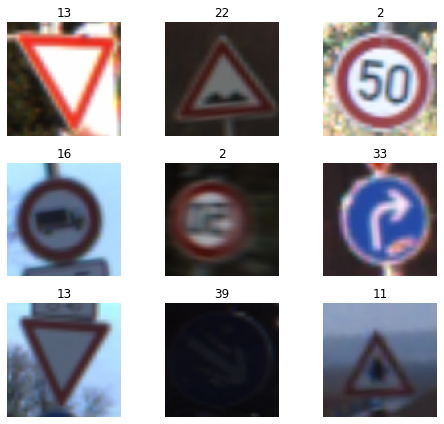

In [89]:
data.show_batch(rows=3, figsize=(7,6))

This is pretty awesome, but, even in this small sample set, there are some gnarly images:  poor lighting, limited resolution of features, etc...  Many of the images are pretty benign though.  Hopefully, I can take an off-the-shelf backbone network and add some fully-connected layers at the top and achieve solid performance.  We'll see if this approach works in the next section.

## Selecting and Training a Model

The [resnet](https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4) family of architectures has achieved amazing things in inference over the last few years because it has allowed researchers to handle the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  Really deep networks can be difficult to train because of this phenomena, but the skip connections present in resnet models overcome this problem.  Why do we want deeper networks?  Simple.  Deeper networks have more parameters and more parameters generally means that more complex relations present in a training set can be better represented.

As with everything in data science, there is a trade-off present between the following factors:

* Training time - we don't want the process to take too long
* Accuracy - we want the model to be accurate, obviously
* Interpretability - we want to understand what the hell is going on with the end model

Generally, interpretability and training time both suffer when the number of parameters increases.  In light of these considerations, I chose resnet34 as the back-bone.

In [92]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, metrics=[accuracy])

You can view a summary of the model structure created above by using the `model` method:

In [ ]:
learn.model

Let's do training for a few epochs and see how well this model learns, shall we?

In [93]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.562474,0.302694,0.897691,01:45
1,0.228094,0.107997,0.965340,01:45
2,0.157664,0.079074,0.974471,01:45


Looks like we are on the right track; the train and valid losses are still going down, the training time per epoch is under two minutes (on a 1080Ti graphics card).  This seems like an approach that we can improve upon in a timely fashion, so let's save our model in it's current state and fine-tune our approach.

In [94]:
learn.save('gtsrb-stage-1')

### Assessing Where We Are So Far

A good place to start is to see which images we are having the greatest difficulty with.  Fastai provides this capability right out-of-the-box:

In [95]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


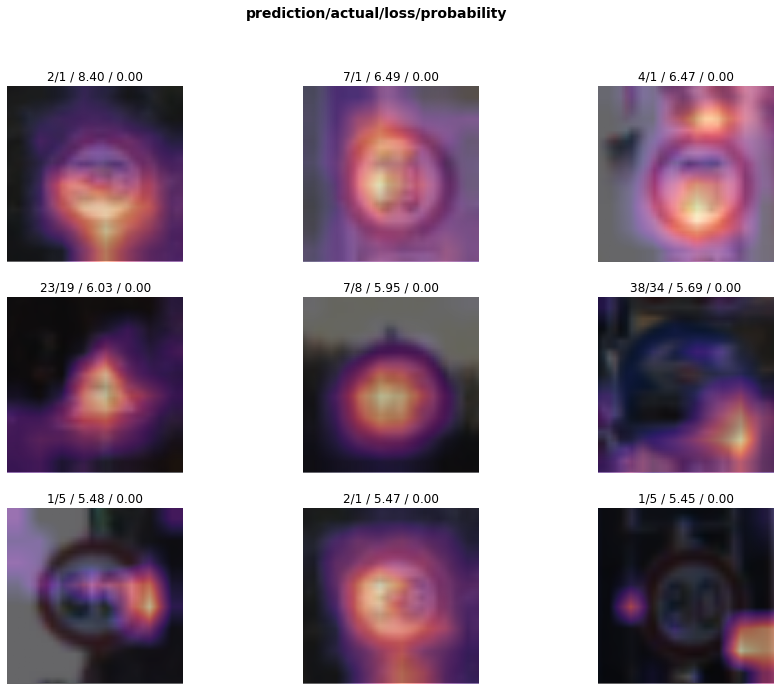

In [96]:
interp.plot_top_losses(9, figsize=(15,11))

Some of these images are pretty gnarly!  Look at the bottom-right one, for crying out loud!  In the original notebook, though, the visualizations had a similar blurring, which could be intentional.  I would have a hard time classifying some of these images, so it's not a big deal that we haven't learned the correct label for these.

A more top-level metric for assessing our classifier's performance is too look at the confusion matrix.

In [25]:
#doc(interp.plot_top_losses)
doc(interp.plot_confusion_matrix)

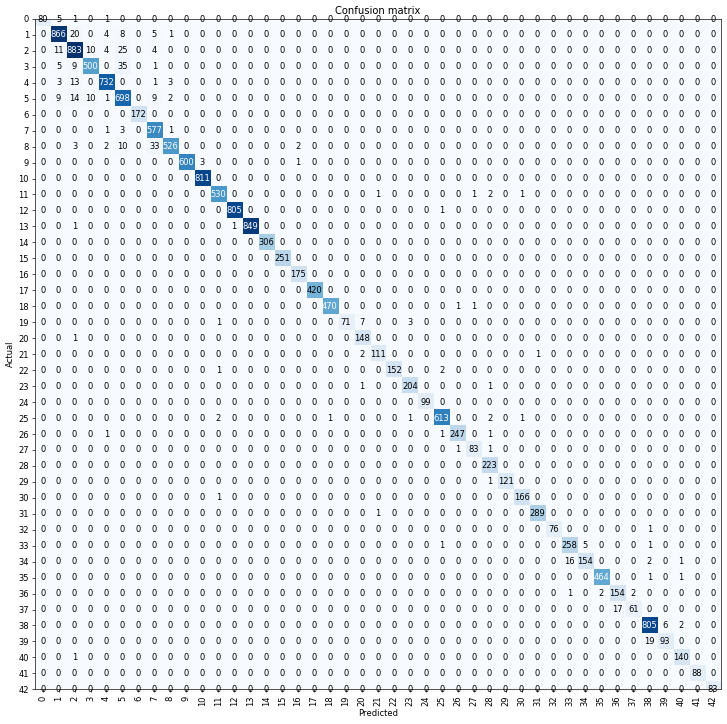

In [97]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [98]:
interp.most_confused(min_val=4)

[(3, 5, 35),
 (8, 7, 33),
 (2, 5, 25),
 (1, 2, 20),
 (39, 38, 19),
 (37, 36, 17),
 (34, 33, 16),
 (5, 2, 14),
 (4, 2, 13),
 (2, 1, 11),
 (2, 3, 10),
 (5, 3, 10),
 (8, 5, 10),
 (3, 2, 9),
 (5, 1, 9),
 (5, 7, 9),
 (1, 5, 8),
 (19, 20, 7),
 (38, 39, 6),
 (0, 1, 5),
 (1, 7, 5),
 (3, 1, 5),
 (33, 34, 5),
 (1, 4, 4),
 (2, 4, 4),
 (2, 7, 4)]

We have some classes present that are really stymying our classifier at this point!  Class 3 images are incorrectly classified as belonging to Class 5 a staggering 8\% of the time!  Moreover, there are several classes that are confusing our network at this point.  Not to worry; we are just beginning to train.

### Unfreezing, Fine-Tuning, and Learning Rates

Since our model is working reasonably well at this point, let's *unfreeze* it and train some more.

In [99]:
learn.load('gtsrb-stage-1')
learn.unfreeze()

In [100]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039360,0.018983,0.993955,02:15


Accuracy looks good, but the train and valid losses are a bit out-of-step with one another.  This step is promising enough to warrant a save, but perhaps we should look at tweaking the learning rate and see if we can improve performance that way.

In [101]:
learn.save('gtsrb-stage-2');

In [102]:
learn.lr_find() # whoops, this doesn't work...

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


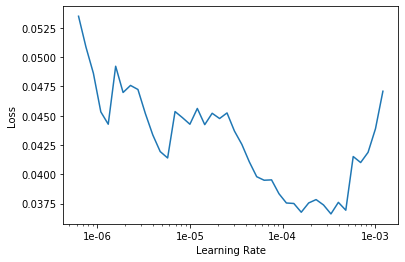

In [103]:
learn.recorder.plot() # clearly don't get that many iterations, check the doc()

Well, this didn't work...  I was hoping to view the loss, and more importantly the change in loss, as a function of the learning rate over 100 iterations, but it looks like the method above failed.  Let's look at the docs.

In [45]:
doc(learn.lr_find)

Cool, now it seems clear what happened:  In the plot above, we can see that the loss is beginning to diverge around 1e-3, and the `lr_find()` triggers an exit when this happens.  Let's try executing the method again.  This time, though, we will narrow the search range and tell the routine not to stop if the loss is diverging.

In [104]:
learn.lr_find(start_lr=1e-8, end_lr=1e-4, stop_div=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


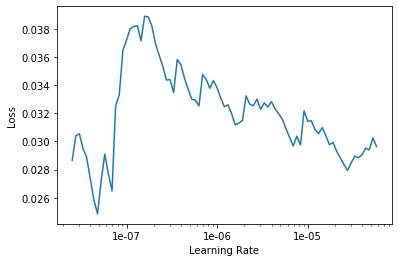

In [105]:
learn.recorder.plot()

This image may just look like noise, but it's not.  We can see a clear macroscopic trend that the rate of loss is consistently negative from about 9e-6 to 1e-5.  We can now use [learning rate annealing](https://www.jeremyjordan.me/nn-learning-rate/), which fastai natively supports, to fine-tune the later stages of training during each epoch.  Let's unfreeze and continue training using learning rate annealing.

In [106]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(9e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.025687,0.015437,0.995885,02:14
1,0.019947,0.009846,0.997299,02:16
2,0.011825,0.006923,0.997878,02:15
3,0.010385,0.004732,0.999100,02:15
4,0.007687,0.004061,0.998585,02:16
5,0.005399,0.002920,0.999035,02:16
6,0.004805,0.002963,0.998971,02:16
7,0.002097,0.002202,0.999357,02:16
8,0.002002,0.002068,0.999357,02:15
9,0.002493,0.002224,0.999164,02:15


Awesome!  We seem to have converged in terms of train and valid losses, and these losses are consistent with each other, by the tenth epoch.  Also, the accuracy number looks awesome.  I'm not concerned about overfitting yet, but this we can assess if our holdout set accuracy is significantly different than the 99.92\% accuracy reported above.  Let's go ahead and save the model.

In [107]:
learn.save('gtsrb-agaigg')  # As Good As It's Going To Get

Let's redo our classfication interpretation analysis from above (a subset of it, anyways).  First, consider what is still confusing our classifier.

In [108]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[(3, 5, 2), (19, 20, 2)]

This is not an issue anymore; only two classes have more than two misclassifications.  For kicks, let's look at the overall confusion matrix.

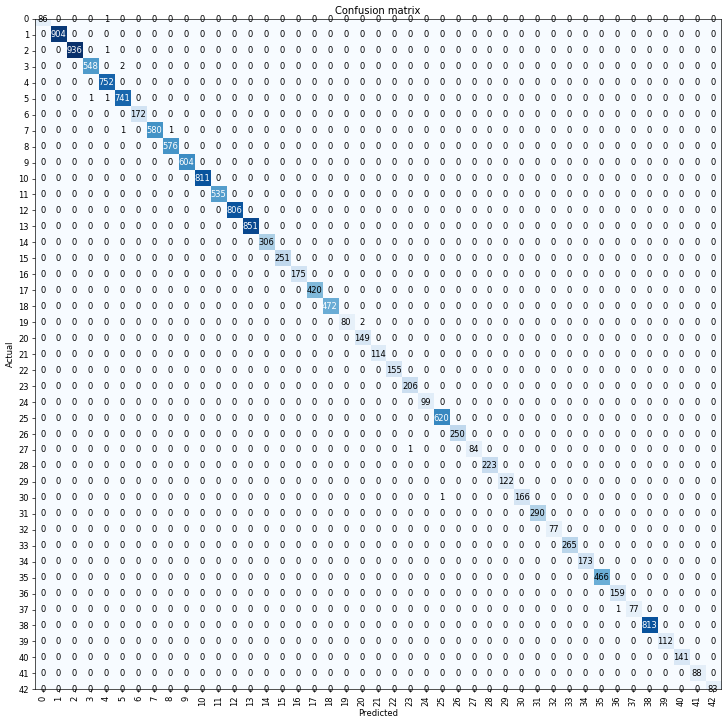

In [109]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

There are no longer hardly any entries present in the off-diagonal, which means that we are classifying exceptionally well.  Let's move on to our test set now.

## Performance on the Test Set

We first export the model. What's great about the fastai library is that, aside from exporting the model weights learned during training, the `export` method also exports the data transformations to be used on the input images.  This is really convenient, since fastai will perform all necessary transformations automatically.

In [110]:
learn.export()

First, let's create our test set.

In [138]:
test_data = ImageList.from_folder(path/"test")
test_data.items

array([PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/41636.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/45271.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/49272.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/39950.png'), ...,
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/47310.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/41847.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/51407.png'),
       PosixPath('/home/joe/nbs/data/gtsdb/xformed/test/43086.png')], dtype=object)

I have printed out the `test_data.items` member variable to highlight an import data structure that will be used later on.  _Note the random order of the returned object._  Let's load the learner we just exported, as well as telling the method which data set we are going to use.

In [139]:
trained_learner = load_learner(path, test=test_data)

We can use the `get_preds` method to do predictions on the entire dataset.

In [143]:
preds, _ = trained_learner.get_preds(ds_type=DatasetType.Test)

In [144]:
preds[:5]

tensor([[2.1014e-07, 5.7699e-07, 4.6946e-08, 1.9493e-07, 2.6473e-07, 2.1289e-08,
         1.3496e-07, 1.0974e-08, 1.0234e-08, 7.8219e-08, 1.3587e-08, 1.6515e-07,
         1.1508e-07, 2.9470e-06, 3.8857e-08, 4.3122e-07, 1.4205e-06, 9.5760e-08,
         4.5615e-08, 5.3949e-06, 5.4691e-07, 4.6975e-07, 1.7363e-06, 7.4102e-10,
         2.4850e-08, 5.1275e-08, 6.9207e-08, 5.6077e-07, 6.6335e-07, 2.3450e-08,
         1.2193e-10, 2.4853e-08, 5.4437e-07, 9.9976e-01, 1.9789e-04, 4.5010e-07,
         8.4502e-06, 1.6368e-06, 3.1704e-07, 5.3876e-08, 1.6155e-06, 6.1851e-06,
         7.9492e-06],
        [6.8519e-08, 2.1272e-07, 8.3908e-08, 1.2190e-07, 4.7836e-08, 1.2757e-08,
         7.7461e-10, 4.0631e-08, 1.9651e-08, 2.3144e-08, 4.8521e-09, 4.4070e-08,
         1.6477e-09, 5.5614e-08, 2.6869e-07, 9.4237e-10, 4.4921e-08, 9.5284e-10,
         1.7851e-10, 2.4341e-09, 8.4882e-10, 3.1840e-10, 8.0760e-09, 5.5333e-09,
         1.3647e-08, 7.0830e-09, 1.2280e-10, 2.9605e-08, 5.4412e-09, 4.5411e-09,
      

The predictions are class probabilities and not labels, but we can do the transformation easily enough.

In [148]:
pred_labels = np.argmax(preds, 1).numpy()

In [149]:
print(pred_labels[:5])

[33 40 35  1 33]


Now, we have class labels, which is great.  Next, we address the out-of-order problem.  We can get the image names by using the `name` method of `PosixPath` objects to get the image filenames with the paths stripped:

In [163]:
image_names = np.array([_t.name for _t in test_data.items])
print(image_names[:5])

['41636.png' '45271.png' '49272.png' '39950.png' '50694.png']


Now, we can use numpy's `argsort` to return the list of indices that sort the original array.  This is important because of how the original dataset was constructed (see the section **Tranform the Data** above); reordering our predictions array to match the ordering in the `labels.csv` file will make accuracy assessment much easier.

In [164]:
sorted_image_idx = np.argsort(image_names)

In [165]:
ordered_preds = pred_labels[sorted_image_idx]

In [166]:
ordered_preds[:5]

array([16,  1, 38, 33, 11])

#### Extract the Ground Truth

We can pull the ground truth from `labels.csv` with the following simple utility:

In [179]:
true_labels = []
with open(path/"labels.csv", 'r') as _f:
    from itertools import dropwhile
    for cur_line in dropwhile(lambda x: x.split(",")[0].startswith('train'), _f):
        _image, _label = cur_line.strip().split(",")
        true_labels.append((_image, int(_label)))

Let's check that this method worked by comparing the first few labels in the `true_labels` data structure with our `ordered_preds` from above.

In [180]:
true_labels[:5]

[('test/39209.png', 16),
 ('test/39210.png', 1),
 ('test/39211.png', 38),
 ('test/39212.png', 33),
 ('test/39213.png', 11)]

Great!  The first five predictions match, so it looks like the ordering has worked.  Let's make sure that the two data structures have the same size, then we can do point-by-point comparison for accuracy.

In [181]:
assert len(true_labels) == ordered_preds.size
acc_ctr = 0
tot_ctr = 0
for _pl, _tl in zip(ordered_preds, true_labels):
    tot_ctr += 1
    if _pl == _tl[1]:
        acc_ctr += 1
    else:
        print('{image} -> Predicted={pred}, Actual={actual}'.format(image=_tl[0], pred=_pl, actual=_tl[1]))
accuracy = float(acc_ctr) / tot_ctr
print("Total Accuracy on Test Set ({images} images): {accuracy}".format(images=len(true_labels), accuracy=accuracy))

test/42045.png -> Predicted=3, Actual=5
test/43066.png -> Predicted=4, Actual=5
test/43220.png -> Predicted=25, Actual=30
test/44850.png -> Predicted=5, Actual=3
test/46620.png -> Predicted=36, Actual=37
test/51605.png -> Predicted=5, Actual=3
Total Accuracy on Test Set (12630 images): 0.9995249406175772


Six images out of 12630 were classified incorrectly.  Only six!  Moreover, four of these involve classes 3 and 5, which we know we had difficulty with during training from our previous analysis.

## Conclusion

Using the fastai library, I was able to demonstrate how to achieve 99.95\% accuracy on the German Traffic Sign Recognition Benchmark dataset.  This result constitutes an improvement to the state-of-the-art method that was used to win a 2011 challenge using this dataset.  Given the high accuracy observed, there is not much more improvement to be achieved.